In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import GradientNormClipping, EarlyStopping
import torch

from model_utils import load_dataset, run_experiment, print_results, plot_residuals

import warnings

C:\Users\drawi\anaconda3\envs\fall22\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class RNNRegressor(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=64, num_layers=1):
        super(RNNRegressor, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = torch.nn.RNN(in_dim, hidden_dim, num_layers, 
                                batch_first=True, nonlinearity='tanh')
        self.linear = torch.nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = x.float()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, requires_grad=True).float()

        out, hn = self.rnn(x, h0)
        out = self.linear(out[:, -1, :]) 
        return out
    

In [3]:
dataset = load_dataset(temporal=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:14<00:00,  3.22s/it]


In [17]:
for test_score in ['sat_math', 'sat_ebrw']:
    dataset['testscores;{}_delta'.format(test_score)] = \
        dataset.apply(lambda r: r['testscores;{}_2022'.format(test_score)] - r['testscores;{}_2019'.format(test_score)],
                      axis=1)
    
for test_score in ['math_4', 'math_8', 'reading_4', 'reading_8']:
    dataset['testscores;{}_delta'.format(test_score)] = \
        dataset.apply(lambda r: r['testscores;{}_2022'.format(test_score)] - r['testscores;{}_2019'.format(test_score)],
                      axis=1)

In [4]:
dataset

engagement;pct_access  engagement;engagement_index  \
district_id                                                                  
1000        2020-01-01               0.236471                    35.756941   
            2020-01-02               1.230658                   132.571535   
            2020-01-03               1.496171                   166.726667   
            2020-01-04               0.173239                    18.352535   
            2020-01-05               0.250220                    26.904176   
...                                       ...                          ...   
9927        2020-12-27               0.102476                    20.223048   
            2020-12-28               0.112883                    25.413063   
            2020-12-29               0.117411                    27.463482   
            2020-12-30               0.104683                    25.258571   
            2020-12-31               0.110619                    32.297629   

                       products;Sector(s) products;Primary Essential Function  \
district_id                                                                     
1000        2020-01-01               None                                None   
            2020-01-02               None                                None   
            2020-01-03               None                                None   
            2020-01-04               None                                None   
            2020-01-05               None                                None   
...                                   ...                                 ...   
9927        2020-12-27               None                                None   
            2020-12-28               None                                None   
            2020-12-29               None                                None   
            2020-12-30               None                                None   
            2020-12-31               None                                None   

                       districts;state districts;locale  \
district_id                                               
1000        2020-01-01     Connecticut           Suburb   
            2020-01-02     Connecticut           Suburb   
            2020-01-03     Connecticut           Suburb   
            2020-01-04     Connecticut           Suburb   
            2020-01-05     Connecticut           Suburb   
...                                ...              ...   
9927        2020-12-27   Massachusetts           Suburb   
            2020-12-28   Massachusetts           Suburb   
            2020-12-29   Massachusetts           Suburb   
            2020-12-30   Massachusetts           Suburb   
            2020-12-31   Massachusetts           Suburb   

                        districts;pct_black/hispanic  \
district_id                                            
1000        2020-01-01                           3.0   
            2020-01-02                           3.0   
            2020-01-03                           3.0   
            2020-01-04                           3.0   
            2020-01-05                           3.0   
...                                              ...   
9927        2020-12-27                           0.0   
            2020-12-28                           0.0   
            2020-12-29                           0.0   
            2020-12-30                           0.0   
            2020-12-31                           0.0   

                       districts;pct_free/reduced districts;pp_total_raw  \
district_id                                                                
1000        2020-01-01                        1.0                    NaN   
            2020-01-02                        1.0                    NaN   
            2020-01-03                        1.0                    NaN   
            2020-01-04                        1.0                    NaN   
  

<a id='models'></a>

# RECURRENT NEURAL NETWORK MODELS

Use each day of data for each district (i.e., each sample is a sequence of length 366 - missing days are linearly interpolated). Same model is used for all states.

This yields only ~147-149 rows, so we use k-fold Cross Validation to measure model performance. _Note that the folds are constructed to ensure that all data from a given state is in either the test or train split._

Unless otherwise noted, all models use engagement data (not split by product type), locale type data, and broadband data, but not the socioeconomic data (due to missing data issues that would reduce the size of the dataset).

RNNs are trained for a maximum of 100 epochs, with early stopping after 3 epochs without improvement.

### 4th and 8th Grade Test Score (& Change) Models

Each baseline trains 4 RNNs, one for each combination of 4th & 8th grade, math & reading test scores, using 5-fold cross-validation. The target variable is either the raw 2022 test scores or the magnitude of the change in test scores from 2019 to 2022, i.e., $score_{2022} - score_{2019}$. 

- ___Model 1a___: Predict raw test scores. ([Model](#model1a_model) / [Results](#model1a_results))
- ___Model 1b___: Predict change in test scores. ([Model](#model1b_model) / [Results](#model1b_results))
- ___Model 2b___: Predict change in test scores from engagement and locale data only (i.e., data used by best baseline models). ([Model](#model2b_model) / [Results](#model2b_results))

### SAT Score (& Change) Models

Each baseline trains 2 RNNs, one for math and one for reading SAT scores, using 5-fold cross-validation. The target variable is either the raw 2022 test scores or the magnitude of the change in test scores from 2019 to 2022, i.e., $score_{2022} - score_{2019}$. 

- ___Model 1c___: Predict raw test scores. ([Model](#model1c_model) / [Results](#model1c_results))
- ___Model 1d___: Predict change in test scores. ([Model](#model1d_model) / [Results](#model1d_results))
- ___Model 2c___: Predict raw test scores from engagement data only (i.e., data used by best baseline model). ([Model](#model2c_model) / [Results](#model2c_results))

<a id='model1a_model'></a>

## Model 1a: Predict 8th and 4th Grade Test Scores from All Data

[(Back to top)](#models)

In [5]:
FEATURES = ['engagement;pct_access',
            'engagement;engagement_index',
            'districts;locale_city', 
            'districts;locale_suburb', 
            'districts;locale_town',
            'districts;locale_rural',
            'broadband;wired_over_25',
            'broadband;avg_mbps', 
            'broadband;frac_access', 
            'broadband;lowest_price']

TARGETS = ['testscores;math_4_2022', 
           'testscores;math_8_2022', 
           'testscores;reading_4_2022', 
           'testscores;reading_8_2022']

model_type = NeuralNetRegressor(
                                RNNRegressor,
                                max_epochs=100,
                                criterion=torch.nn.MSELoss(),
                                lr=0.01,
                                # Shuffle training data on each epoch
                                iterator_train__shuffle=True,
                                # Network parameters
                                module__in_dim=len(FEATURES),
                                module__hidden_dim=64,
                                module__num_layers=3,
                                callbacks=[
                                    ('gradient_clipping',
                                     GradientNormClipping(gradient_clip_value=50.0)),
                                    ('early_stopping',
                                     EarlyStopping(patience=3)),
                                ],
)

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   TARGETS,
                                   model_type, 
                                   n_splits=5,
                                   scoring_metrics_list=['neg_root_mean_squared_error'],
                                   temporal=True)


Dataset for testscores;math_4_2022 has 149 samples after filtering
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    57691.3359    57272.7461  0.6833
      2    57204.5273    56307.4414  0.6573
      3    56240.0312    54916.6562  0.6503
      4    54847.9141    53355.0430  0.6034
      5    53289.3164    51708.0117  0.5614
      6    51644.3281    50011.7500  0.5384
      7    49949.8008    48299.1094  0.5105
      8    48238.6562    46591.2930  0.5085
      9    46532.1484    44899.0273  0.4625
     10    44841.0312    43228.8789  0.5055
     11    43171.9492    41584.9297  0.4525
     12    41529.0195    39968.5820  0.5095
     13    39913.6484    38380.3320  0.4615
     14    38326.3594    36821.5352  0.4485
     15    36768.4883    35293.6758  0.4276
     16    35241.5430    33797.6211  0.4306
     17    33746.3711    32333.7129  0.4136
     18    32283.3320    30902.1035  0.4356
     19    30852.5703    29502.8691  0.4336
     20  

     63       41.6742       69.4658  0.4236
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    57796.7539    56302.6250  0.6723
      2    57209.1797    55191.5938  0.6354
      3    56084.8320    53729.5195  0.6493
      4    54615.3477    52123.7461  0.5744
      5    52998.0938    50442.9570  0.5754
      6    51304.4648    48728.4219  0.5304
      7    49576.0469    47007.7383  0.5234
      8    47840.8164    45298.3594  0.4715
      9    46116.4688    43610.3086  0.4745
     10    44413.1719    41949.4609  0.4685
     11    42736.9258    40318.7656  0.4585
     12    41090.7266    38719.4492  0.4755
     13    39475.8242    37152.0078  0.4885
     14    37892.7617    35616.6914  0.4735
     15    36341.7695    34113.6289  0.5095
     16    34823.0117    32642.8887  0.4545
     17    33336.5547    31204.5293  0.4875
     18    31882.4609    29798.5723  0.4216
     19    

     65       42.3867       46.1333  0.4496
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    56946.3125    56355.1367  0.7362
      2    56471.5586    55450.6836  0.6783
      3    55565.6445    54155.3086  0.6693
      4    54261.9062    52650.3750  0.6174
      5    52752.9844    51022.5586  0.5654
      6    51122.8008    49327.9844  0.5664
      7    49427.7188    47610.6133  0.5395
      8    47710.1523    45895.8750  0.5065
      9    45994.7969    44198.3008  0.4895
     10    44296.2070    42526.4023  0.5075
     11    42623.0000    40884.1914  0.4675
     12    40979.2461    39273.2070  0.4755
     13    39366.5508    37694.0664  0.4675
     14    37785.5781    36147.0391  0.4585
     15    36236.6289    34632.2695  0.4615
     16    34719.8711    33149.8398  0.4715
     17    33235.4023    31699.7969  0.4745
     18    31783.2715    30282.1699  0.5115
     19    

     62     1993.9250     1518.3563  0.4715
     63     1653.4224     1230.3673  0.3996
     64     1345.4205      974.8787  0.3966
     65     1069.9183      751.8904  0.4386
     66      826.9151      561.4034  0.3956
     67      616.4124      403.4173  0.3806
     68      438.4099      277.9314  0.4286
     69      292.9068      184.9456  0.4086
     70      179.9028      124.4611  0.4116
     71       99.3997       96.4769  0.4096
     72       51.3964      100.9934  0.4096
     73       35.8928      100.3877  0.3886
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    77895.8438    76474.7500  0.6193
      2    77164.0078    75145.5781  0.6393
      3    75823.3047    73457.8359  0.6473
      4    74129.7109    71610.3125  0.5954
      5    72275.2344    69692.7734  0.5614
      6    70349.5156    67740.7734  0.5275
      7    68388.3750    65767.9766  0.5345
      8    

     43    14205.0654    12872.3828  0.4405
     44    13262.1035    11977.2705  0.4435
     45    12351.6367    11114.6602  0.4366
     46    11473.6729    10284.5459  0.4785
     47    10628.2031     9486.9346  0.4316
     48     9815.2363     8721.8223  0.4505
     49     9034.7686     7989.2056  0.4386
     50     8286.7979     7289.0923  0.4475
     51     7571.3286     6621.4766  0.4605
     52     6888.3560     5986.3633  0.4875
     53     6237.8857     5383.7485  0.4895
     54     5619.9150     4813.6313  0.4425
     55     5034.4414     4276.0171  0.4475
     56     4481.4707     3770.9023  0.4346
     57     3960.9988     3298.2852  0.4855
     58     3473.0239     2858.1699  0.4775
     59     3017.5522     2450.5525  0.4316
     60     2594.5779     2075.4375  0.4945
     61     2204.1052     1732.8223  0.4146
     62     1846.1320     1422.7054  0.4236
     63     1520.6580     1145.0900  0.4036
     64     1227.6846      899.9744  0.4785
     65      967.2114      687.3

     24    37762.4883    35719.6953  0.4206
     25    36212.9883    34214.1406  0.4266
     26    34695.9648    32741.0781  0.4405
     27    33211.4219    31300.5156  0.4206
     28    31759.3594    29892.4473  0.4206
     29    30339.7812    28516.8691  0.4465
     30    28952.6914    27173.7988  0.4465
     31    27598.0938    25863.2266  0.4535
     32    26275.9902    24585.1504  0.4615
     33    24986.3770    23339.5781  0.4865
     34    23729.2598    22126.5059  0.4286
     35    22504.6348    20945.9316  0.4505
     36    21312.5059    19797.8613  0.4386
     37    20152.8750    18682.2949  0.5005
     38    19025.7441    17599.2227  0.4795
     39    17931.1016    16548.6562  0.4415
     40    16868.9648    15530.5889  0.4455
     41    15839.3223    14545.0244  0.4146
     42    14842.1797    13591.9570  0.4765
     43    13877.5332    12671.3975  0.4396
     44    12945.3906    11783.3359  0.4296
     45    12045.7451    10927.7764  0.4176
     46    11178.5957    10104.7

     17    27516.6367    25703.5781  0.4775
     18    26197.5098    24429.6387  0.4765
     19    24910.5293    23188.0312  0.4415
     20    23655.8691    21978.8438  0.4475
     21    22433.6133    20802.0957  0.4785
     22    21243.7949    19657.8223  0.4535
     23    20086.4336    18546.0176  0.4945
     24    18961.5391    17466.6934  0.4805
     25    17869.1191    16419.8555  0.4645
     26    16809.1836    15405.5039  0.4875
     27    15781.7275    14423.6436  0.5035
     28    14786.7617    13474.2734  0.4765
     29    13824.2812    12557.3975  0.4625
     30    12894.2920    11673.0156  0.4445
     31    11996.7949    10821.1260  0.4465
     32    11131.7910    10001.7334  0.4535
     33    10299.2803     9214.8369  0.4565
     34     9499.2627     8460.4385  0.4585
     35     8731.7451     7738.5337  0.4955
     36     7996.7183     7049.1304  0.4995
     37     7294.1909     6392.2212  0.4725
     38     6624.1577     5767.8140  0.4915
     39     5986.6245     5175.9

     27    15873.0615    14757.2822  0.5075
     28    14875.4512    13795.9209  0.4425
     29    13910.3291    12867.0557  0.4805
     30    12977.6963    11970.6875  0.4266
     31    12077.5557    11106.8193  0.4496
     32    11209.9082    10275.4502  0.5245
     33    10374.7549     9476.5801  0.4336
     34     9572.0977     8710.2109  0.4326
     35     8801.9346     7976.3433  0.4775
     36     8064.2690     7274.9722  0.4286
     37     7359.0972     6606.1040  0.4425
     38     6686.4263     5969.7344  0.4585
     39     6046.2505     5365.8677  0.4565
     40     5438.5752     4794.4995  0.4575
     41     4863.3955     4255.6333  0.4186
     42     4320.7163     3749.2686  0.4216
     43     3810.5349     3275.4016  0.4575
     44     3332.8511     2834.0383  0.4545
     45     2887.6677     2425.1733  0.4465
     46     2474.9824     2048.8105  0.4356
     47     2094.7974     1704.9486  0.4356
     48     1747.1116     1393.5863  0.4326
     49     1431.9238     1114.7

     35    18549.8535    16840.5430  0.4166
     36    17468.7910    15812.1484  0.4186
     37    16420.2227    14816.2471  0.4176
     38    15404.1504    13852.8477  0.4156
     39    14420.5752    12921.9404  0.4515
     40    13469.4961    12023.5381  0.4196
     41    12550.9150    11157.6299  0.4376
     42    11664.8291    10324.2236  0.4086
     43    10811.2422     9523.3154  0.4216
     44     9990.1543     8754.9053  0.4226
     45     9201.5625     8018.9976  0.4196
     46     8445.4707     7315.5854  0.4256
     47     7721.8750     6644.6753  0.3726
     48     7030.7803     6006.2612  0.4525
     49     6372.1826     5400.3506  0.4026
     50     5746.0859     4826.9390  0.4246
     51     5152.4868     4286.0249  0.4126
     52     4591.3857     3777.6123  0.3816
     53     4062.7859     3301.6980  0.3936
     54     3566.6831     2858.2849  0.4036
     55     3103.0815     2447.3721  0.4276
     56     2671.9792     2068.9573  0.4515
     57     2273.3748     1723.0

     25    30924.6270    28978.8203  0.4485
     26    29524.0000    27624.0645  0.4276
     27    28155.8535    26301.7988  0.4515
     28    26820.1934    25012.0312  0.4565
     29    25517.0156    23754.7559  0.4485
     30    24246.3359    22529.9707  0.4336
     31    23008.1406    21337.6836  0.4725
     32    21802.4395    20177.8945  0.4455
     33    20629.2363    19050.6035  0.4725
     34    19488.5234    17955.8105  0.4315
     35    18380.3086    16893.5117  0.4266
     36    17304.5859    15863.7148  0.4505
     37    16261.3643    14866.4131  0.4525
     38    15250.6348    13901.6143  0.4196
     39    14272.4053    12969.3125  0.4386
     40    13326.6719    12069.5127  0.4316
     41    12413.4385    11202.2139  0.4575
     42    11532.7021    10367.4072  0.4485
     43    10684.4639     9565.1064  0.4386
     44     9868.7246     8795.3037  0.4485
     45     9085.4824     8058.0005  0.4266
     46     8334.7422     7353.1987  0.4386
     47     7616.5015     6680.8

     14    49180.0391    46859.9648  0.4695
     15    47414.4375    45134.8242  0.4455
     16    45678.5898    43440.8945  0.4575
     17    43973.9492    41778.8711  0.4585
     18    42301.1875    40149.0234  0.4485
     19    40660.6016    38551.4883  0.4435
     20    39052.3164    36986.3203  0.4475
     21    37476.3945    35453.5664  0.4246
     22    35932.8867    33953.2383  0.4545
     23    34421.8008    32485.3652  0.4486
     24    32943.1641    31049.9512  0.4425
     25    31496.9805    29647.0020  0.4186
     26    30083.2656    28276.5293  0.4366
     27    28702.0234    26938.5332  0.4096
     28    27353.2559    25633.0215  0.4156
     29    26036.9707    24359.9941  0.4575
     30    24753.1699    23119.4512  0.4206
     31    23501.8535    21911.4043  0.4026
     32    22283.0273    20735.8438  0.4295
     33    21096.6934    19592.7793  0.3946
     34    19942.8477    18482.2051  0.3936
     35    18821.4961    17404.1270  0.4076
     36    17732.6387    16358.5

<a id='model1a_results'></a>

### Model 1a Testing Results

[(Back to top)](#models)

In [7]:
print_results(five_fold_results, scoring_metrics_list=['neg_root_mean_squared_error'], splits=['test'])

,testscores;math_4_2022
test_root_mean_squared_error,7.1673


testscores;math_4_2022: 7.1673


,testscores;math_8_2022
test_root_mean_squared_error,6.8557


testscores;math_8_2022: 6.8557


,testscores;reading_4_2022
test_root_mean_squared_error,7.7747


testscores;reading_4_2022: 7.7747


,testscores;reading_8_2022
test_root_mean_squared_error,5.7548


testscores;reading_8_2022: 5.7548


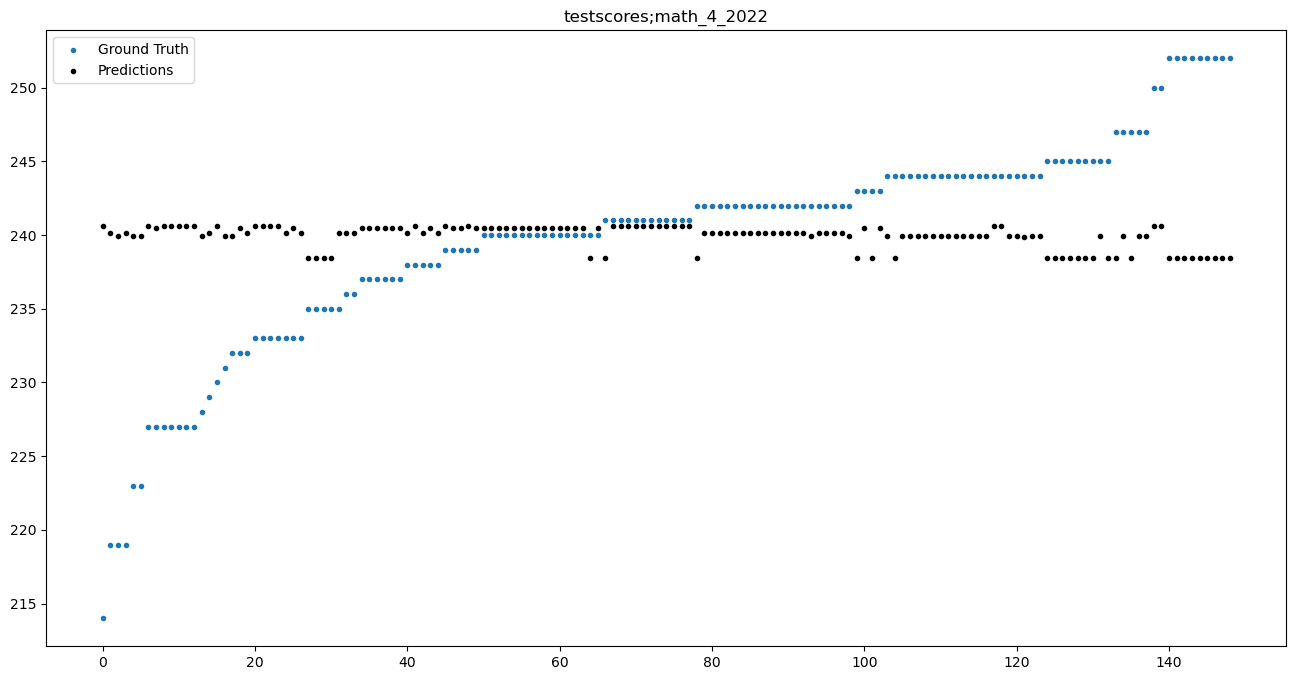

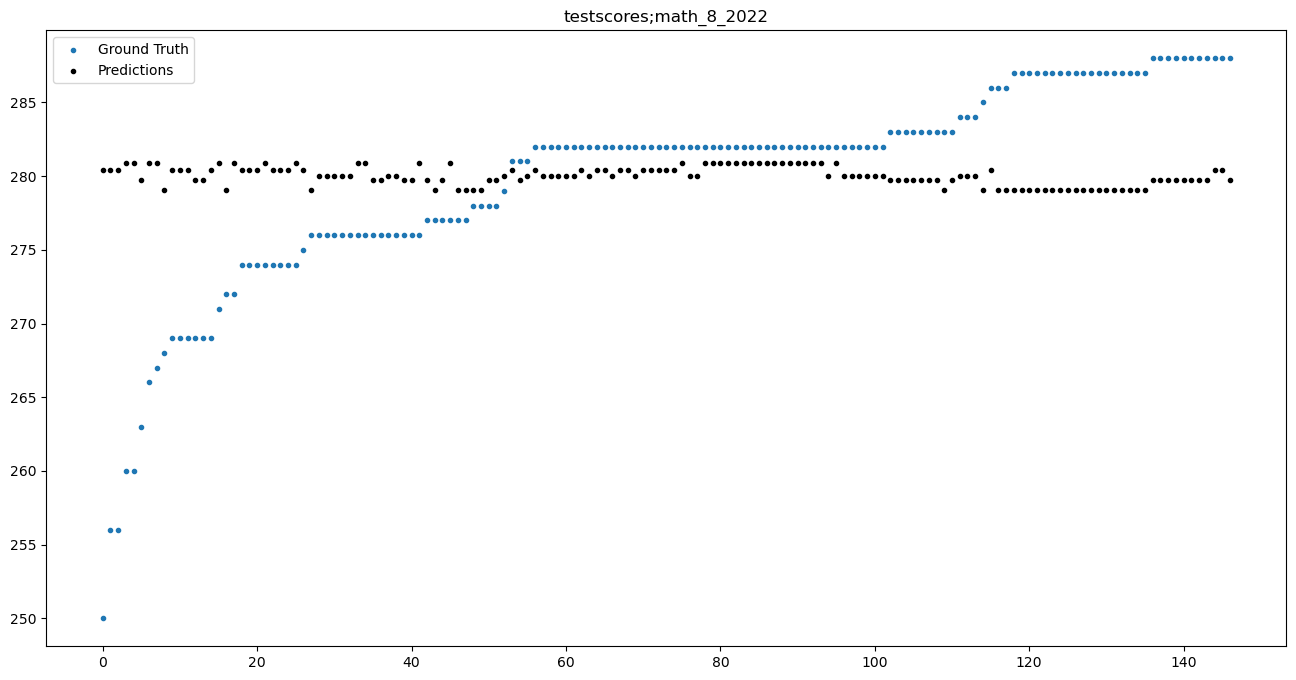

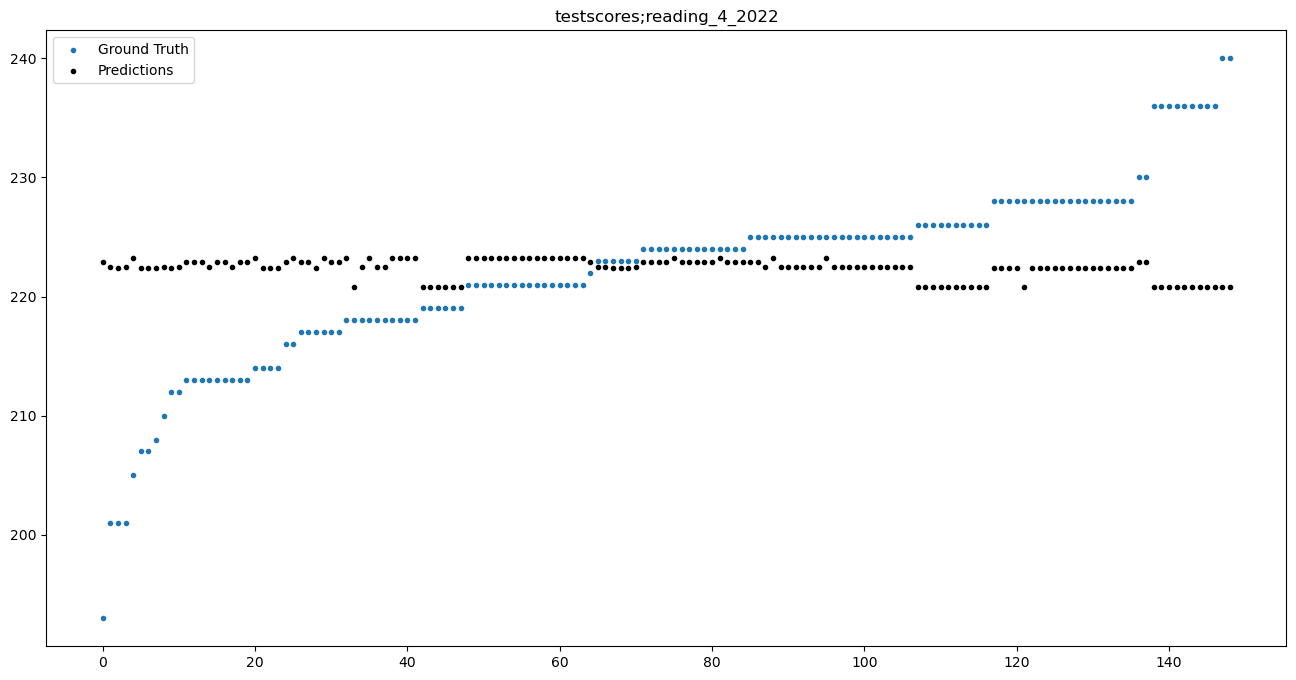

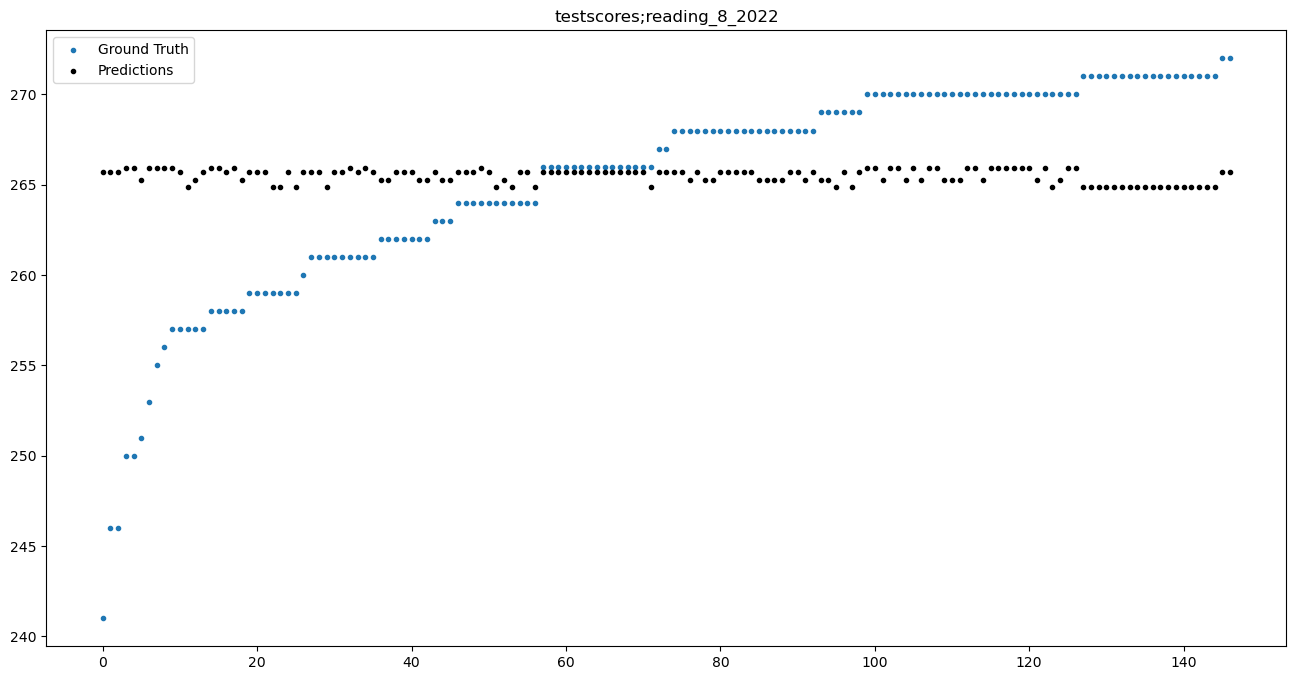

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_residuals(five_fold_results)

<a id='model1b_model'></a>

## Model 1b: Predict Change In 8th and 4th Grade Test Scores from All Data

[(Back to top)](#models)

In [18]:
FEATURES = ['engagement;pct_access',
            'engagement;engagement_index',
            'districts;locale_city', 
            'districts;locale_suburb', 
            'districts;locale_town',
            'districts;locale_rural',
            'broadband;wired_over_25',
            'broadband;avg_mbps', 
            'broadband;frac_access', 
            'broadband;lowest_price']

TARGETS = ['testscores;math_4_delta', 
           'testscores;math_8_delta', 
           'testscores;reading_4_delta', 
           'testscores;reading_8_delta']

model_type = NeuralNetRegressor(
                                RNNRegressor,
                                max_epochs=100,
                                criterion=torch.nn.MSELoss(),
                                lr=0.01,
                                # Shuffle training data on each epoch
                                iterator_train__shuffle=True,
                                # Network parameters
                                module__in_dim=len(FEATURES),
                                module__hidden_dim=64,
                                module__num_layers=3,
                                callbacks=[
                                    ('gradient_clipping',
                                     GradientNormClipping(gradient_clip_value=50.0)),
                                    ('early_stopping',
                                     EarlyStopping(patience=3)),
                                ],
)

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   TARGETS,
                                   model_type, 
                                   n_splits=5,
                                   scoring_metrics_list=['neg_root_mean_squared_error'],
                                   temporal=True)


Dataset for testscores;math_4_delta has 149 samples after filtering
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       29.4808       30.6158  0.7213
      2       26.0370       26.4137  0.7852
      3       21.9393       20.5770  0.6763
      4       16.4163       15.7073  0.6663
      5       12.1625       14.1714  0.6753
      6       10.9884       13.8202  0.5954
      7       10.6283       13.7946  0.5884
      8       10.2062       14.3106  0.5954
      9        9.9609       14.0610  0.5874
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       26.7091       34.7677  0.6543
      2       22.1336       28.9776  0.6763
      3       17.2354       22.2255  0.6723
      4       11.9039       17.7605  0.7123
      5        8.9202       16.2690  0.6373
      6        8.2440       15.8824  0.6284
      7        8.1272       15.

     13        9.9080       10.4392  0.5514
     14        8.8625        6.9991  0.5434
     15        7.9111        5.3015  0.5714
     16        7.1386        4.8601  0.5974
     17        6.5024        4.5069  0.5574
     18        5.7593        4.4985  0.5694
     19        5.1686        3.9837  0.5624
     20        4.9356       16.0397  0.6054
     21       11.1108        9.4719  0.5604
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       84.2589       73.7638  0.6843
      2       72.8577       55.2276  0.6543
      3       54.7052       28.2419  0.6344
      4       27.3303       13.5714  0.5684
      5       12.0467        8.4710  0.5295
      6        9.8060        5.0389  0.5524
      7       19.3300        5.9328  0.5664
      8       17.0505        6.4714  0.5664
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_los

     37        7.4491       16.9867  0.6573
     38        7.4112       16.9245  0.6663
     39        7.3689       16.8521  0.6663
     40        7.3212       16.7658  0.6863
     41        7.2669       16.6604  0.6553
     42        7.2046       16.5289  0.6593
     43        7.1326       16.3628  0.6613
     44        7.0486       16.1538  0.6374
     45        6.9503       15.8992  0.5904
     46        6.8352       15.6098  0.6074
     47        6.7006       15.3088  0.5734
     48        6.5391       15.0218  0.6373
     49        6.3416       14.6973  0.5794
     50        6.1385       14.4566  0.6194
     51        6.2054       18.6666  0.5684
     52        8.3099       17.0769  0.6813
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       19.8088       22.0014  0.6823
      2       15.6072       16.9044  0.6463
      3       11.1529       12.5912  0.6284
      4    

     22        6.8026        5.7390  0.6064
     23        6.6625        5.6030  0.6224
     24        6.5239        5.4401  0.5634
     25        6.3899        5.2644  0.5934
     26        6.2611        5.0962  0.6024
     27        6.1399        4.9256  0.6104
     28        6.1940        7.9490  0.6363
     29        9.9825        6.0102  0.6184
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       18.1120       15.1421  0.6693
      2       16.5281       13.9405  0.6753
      3       15.1305       12.7351  0.6433
      4       13.7044       11.5564  0.6084
      5       12.2914       10.5862  0.6224
      6       11.1187        9.9830  0.6204
      7       10.3809        9.6998  0.6344
      8       10.0275        9.5744  0.6234
      9        9.8760        9.4920  0.6563
     10        9.7951        9.4062  0.6004
     11        9.7301        9.3022  0.6004
     12    

<a id='model1b_results'></a>

### Model 1b Testing Results

[(Back to top)](#models)

In [19]:
print_results(five_fold_results, scoring_metrics_list=['neg_root_mean_squared_error'], splits=['test'])

,testscores;math_4_delta
test_root_mean_squared_error,3.5616


testscores;math_4_delta: 3.5616


,testscores;math_8_delta
test_root_mean_squared_error,3.3633


testscores;math_8_delta: 3.3633


,testscores;reading_4_delta
test_root_mean_squared_error,3.0925


testscores;reading_4_delta: 3.0925


,testscores;reading_8_delta
test_root_mean_squared_error,3.5844


testscores;reading_8_delta: 3.5844


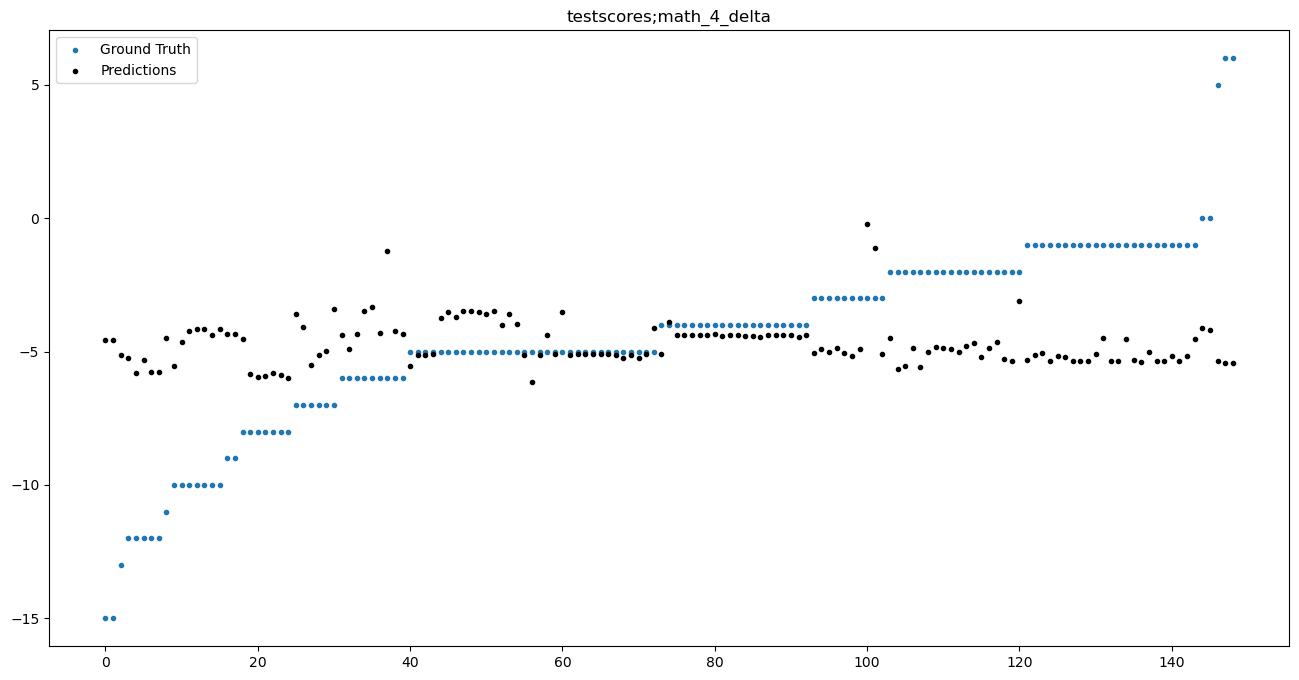

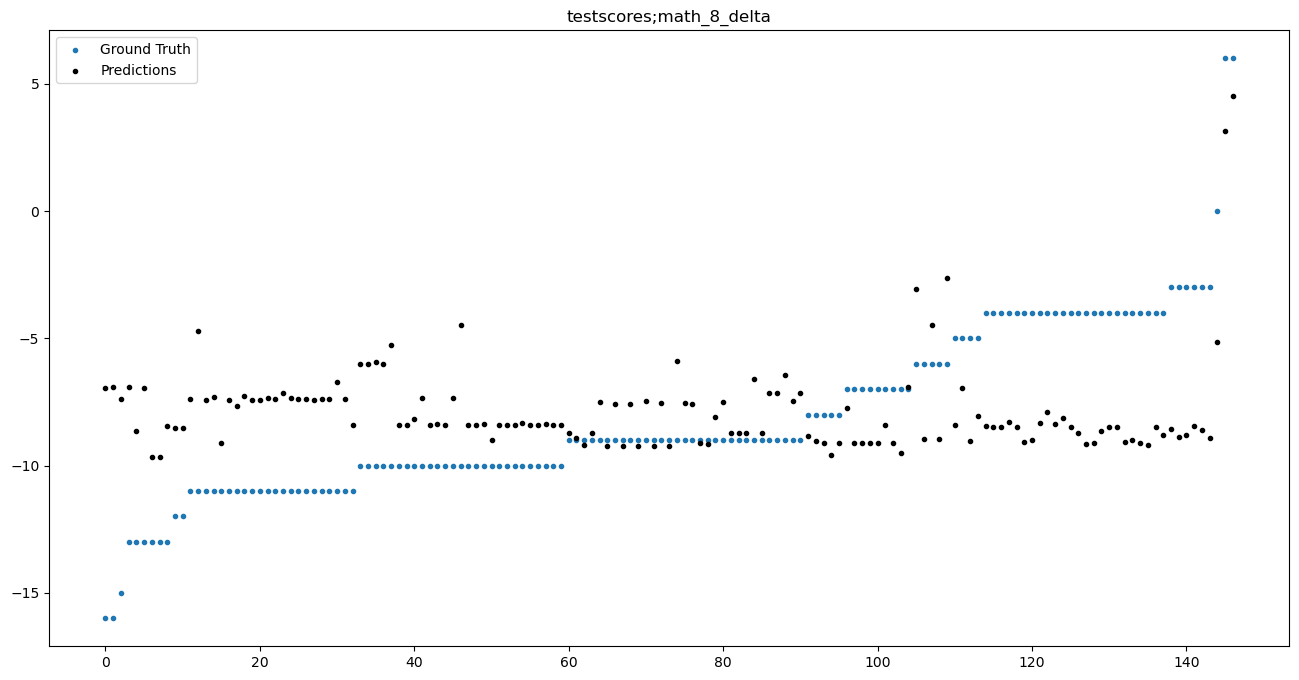

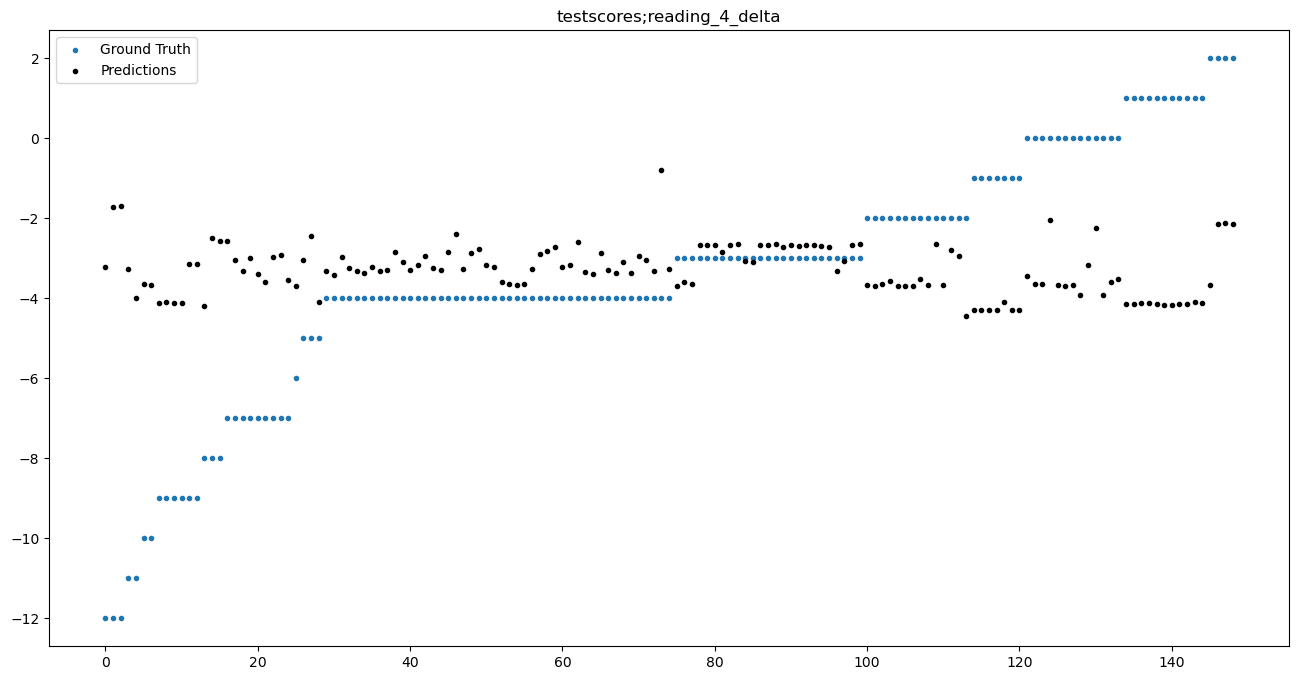

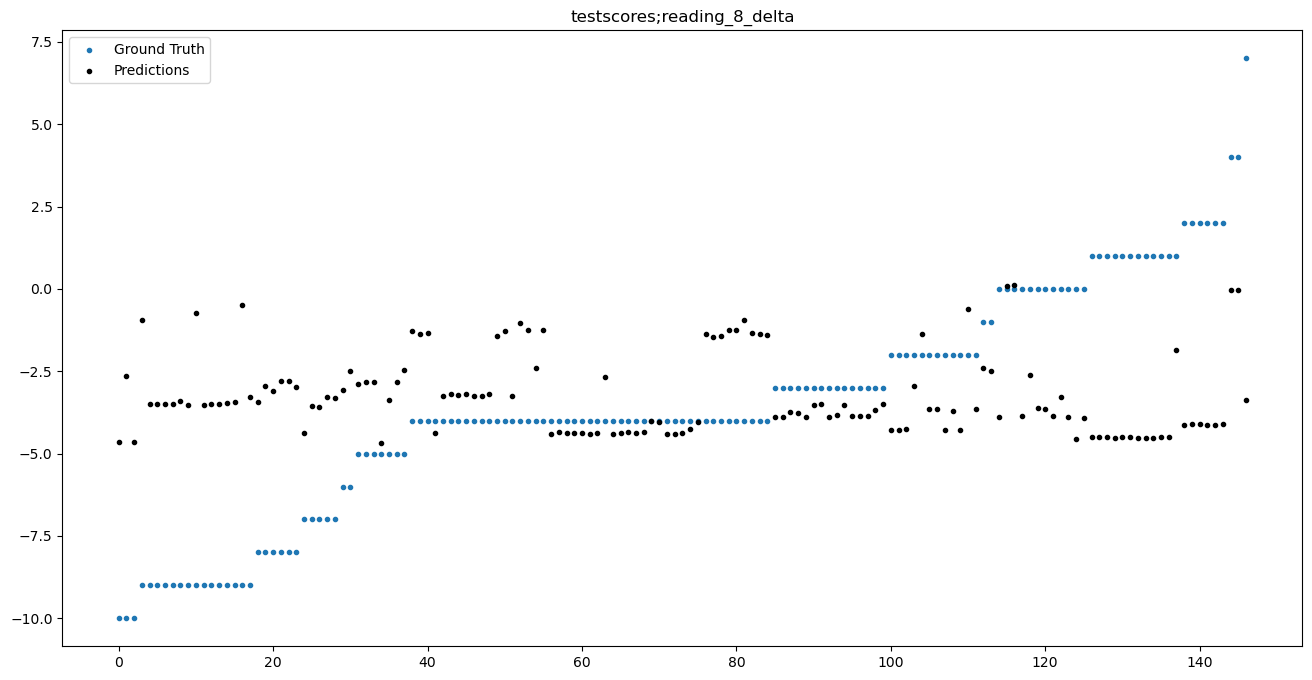

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_residuals(five_fold_results)

<a id='model1c_model'></a>

## Model 1c: Predict SAT Scores from All Data

[(Back to top)](#models)

In [21]:
FEATURES = ['engagement;pct_access',
            'engagement;engagement_index',
            'districts;locale_city', 
            'districts;locale_suburb', 
            'districts;locale_town',
            'districts;locale_rural',
            'broadband;wired_over_25',
            'broadband;avg_mbps', 
            'broadband;frac_access', 
            'broadband;lowest_price']

TARGETS = ['testscores;sat_math_2022', 
           'testscores;sat_ebrw_2022']

model_type = NeuralNetRegressor(
                                RNNRegressor,
                                max_epochs=100,
                                criterion=torch.nn.MSELoss(),
                                lr=0.01,
                                # Shuffle training data on each epoch
                                iterator_train__shuffle=True,
                                # Network parameters
                                module__in_dim=len(FEATURES),
                                module__hidden_dim=64,
                                module__num_layers=3,
                                callbacks=[
                                    ('gradient_clipping',
                                     GradientNormClipping(gradient_clip_value=50.0)),
                                    ('early_stopping',
                                     EarlyStopping(patience=3)),
                                ],
)

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   TARGETS,
                                   model_type, 
                                   n_splits=5,
                                   scoring_metrics_list=['neg_root_mean_squared_error'],
                                   temporal=True)


Dataset for testscores;sat_math_2022 has 150 samples after filtering
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   310975.4062   296169.9688  0.6403
      2   309361.4062   293362.1562  0.6643
      3   306475.5938   289831.2188  0.5824
      4   302875.9688   286026.4688  0.5754
      5   298993.4688   282071.6562  0.5984
      6   294956.2812   278036.3750  0.5374
      7   290835.0312   273958.2812  0.5225
      8   286668.6562   269859.1250  0.4645
      9   282479.8125   265758.6562  0.5305
     10   278288.7812   261673.3906  0.4935
     11   274112.4375   257611.7344  0.4935
     12   269959.3125   253575.0781  0.4336
     13   265830.9062   249561.9375  0.4795
     14   261725.5781   245572.0469  0.4895
     15   257643.2969   241608.7969  0.4775
     16   253587.5000   237675.4219  0.4855
     17   249561.5000   233773.5156  0.4326
     18   245566.8906   229903.6875  0.4316
     19   241604.2656   226066.0781  0.4655
     20

     30   189907.1719   181362.0469  0.4905
     31   186431.5625   177957.9844  0.5075
     32   182988.4844   174586.3906  0.4985
     33   179577.8906   171247.3125  0.5015
     34   176199.7656   167940.7500  0.4945
     35   172854.1562   164666.6719  0.4515
     36   169541.0156   161425.1250  0.4575
     37   166260.3750   158216.0469  0.4685
     38   163012.2344   155039.5156  0.4765
     39   159796.5938   151895.4531  0.5285
     40   156613.4531   148783.8906  0.4575
     41   153462.7656   145704.8750  0.4845
     42   150344.6406   142658.3125  0.4905
     43   147258.9844   139644.2969  0.4705
     44   144205.8281   136662.7656  0.4965
     45   141185.1719   133713.7344  0.4735
     46   138197.0000   130797.1953  0.5005
     47   135241.3281   127913.1641  0.4885
     48   132318.1719   125061.6484  0.4795
     49   129427.5234   122242.6484  0.4366
     50   126569.3516   119456.1016  0.4965
     51   123743.6875   116702.1172  0.4545
     52   120950.5234   113980.6

     61    89705.6875    89395.0703  0.4465
     62    87324.5391    87016.8672  0.4106
     63    84975.8984    84671.1328  0.4406
     64    82659.7422    82357.9297  0.4325
     65    80376.0938    80077.2031  0.4326
     66    78124.9375    77828.9844  0.5105
     67    75906.2891    75613.2734  0.4326
     68    73720.1406    73430.0547  0.4186
     69    71566.5000    71279.3203  0.4595
     70    69445.3359    69161.1094  0.4376
     71    67356.6797    67075.3906  0.4376
     72    65300.5312    65022.1836  0.4425
     73    63276.8789    63001.4688  0.4505
     74    61285.7383    61013.2500  0.4635
     75    59327.0898    59057.5273  0.4675
     76    57400.9336    57134.3125  0.4336
     77    55507.2812    55243.5977  0.4076
     78    53646.1367    53385.3906  0.4535
     79    51817.4883    51559.6719  0.4605
     80    50021.3398    49766.4492  0.4565
     81    48257.6836    48005.7305  0.4665
     82    46526.5312    46277.5195  0.3946
     83    44827.8867    44581.8

     92    39427.3594    34238.5781  0.4795
     93    37884.9336    32788.5195  0.5105
     94    36375.0039    31370.9609  0.4525
     95    34897.5742    29985.9062  0.4495
     96    33452.6523    28633.3340  0.4505
     97    32040.2129    27313.2754  0.4206
     98    30660.2812    26025.7188  0.4206
     99    29312.8594    24770.6621  0.4835
    100    27997.9297    23548.1035  0.4306
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   311198.0000   295830.4062  0.6443
      2   310065.1250   293829.6250  0.6393
      3   307988.5938   290793.6562  0.6504
      4   304865.5312   287279.9688  0.5944
      5   301276.2500   283487.0312  0.5654
      6   297401.4688   279517.2812  0.5205
      7   293343.2188   275456.6562  0.5495
      8   289190.0312   271363.1562  0.4995
      9   285001.4688   267263.8438  0.4935
     10   280805.4688   263174.0312  0.4895
     11   276617.7812   259102.7031  0.4445
     12   272447.9688   255052.5

     21   241616.6094   228287.7656  0.4615
     22   237684.0781   224462.7344  0.4515
     23   233783.8594   220670.1250  0.4316
     24   229916.0625   216910.0000  0.4765
     25   226080.7031   213182.3281  0.5005
     26   222277.7656   209487.1250  0.4905
     27   218507.2969   205824.4219  0.4685
     28   214769.2656   202194.1719  0.4495
     29   211063.7031   198596.4375  0.4715
     30   207390.6250   195031.1875  0.4615
     31   203750.0469   191498.4375  0.4266
     32   200141.9375   187998.1719  0.4565
     33   196566.2969   184530.3906  0.4675
     34   193023.1406   181095.1250  0.4745
     35   189512.4844   177692.3281  0.4665
     36   186034.3125   174322.0469  0.4555
     37   182588.6250   170984.2656  0.4635
     38   179175.4375   167678.9688  0.4515
     39   175794.7344   164406.1719  0.4156
     40   172446.5156   161165.9062  0.4495
     41   169130.8125   157958.1094  0.4775
     42   165847.5938   154782.7969  0.4645
     43   162596.8906   151640.0

     52   126484.3359   120925.9375  0.4356
     53   123655.6328   118153.2500  0.4236
     54   120859.4609   115413.0312  0.4495
     55   118095.7422   112705.3359  0.4435
     56   115364.5547   110030.1250  0.4256
     57   112665.8516   107387.4297  0.4186
     58   109999.6328   104777.2266  0.4376
     59   107365.9375   102199.5312  0.4116
     60   104764.7500    99654.3125  0.4206
     61   102196.0391    97141.6172  0.4156
     62    99659.8359    94661.4062  0.4515
     63    97156.1328    92213.6953  0.4685
     64    94684.9297    89798.5000  0.4445
     65    92246.2188    87415.7891  0.4356
     66    89840.0078    85065.5859  0.4635
     67    87466.2891    82747.8828  0.4455
     68    85125.0859    80462.6719  0.4386
     69    82816.3828    78209.9688  0.4685
     70    80540.1797    75989.7734  0.4046
     71    78296.4688    73802.0469  0.4026
     72    76085.2500    71646.8516  0.4336
     73    73906.5391    69524.1484  0.4276
     74    71760.3359    67433.9

     83    48960.9727    49013.3125  0.4186
     84    47213.9844    47264.2070  0.4206
     85    45499.4961    45547.5938  0.4226
     86    43817.4844    43863.4961  0.4126
     87    42167.9922    42211.8906  0.3896
     88    40551.0000    40592.7852  0.3936
     89    38966.5039    39006.1836  0.4326
     90    37414.5156    37452.0703  0.3986
     91    35895.0078    35930.4648  0.4046
     92    34408.0156    34441.3633  0.4096
     93    32953.5195    32984.7617  0.4256
     94    31531.5312    31560.6562  0.4156
     95    30142.0332    30169.0527  0.4066
     96    28785.0371    28809.9434  0.4146
     97    27460.5371    27483.3379  0.3946
     98    26168.5391    26189.2344  0.4216
     99    24909.0410    24927.6309  0.4066
    100    23682.0527    23698.5254  0.4256
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   315559.2500   306762.5000  0.6344
      2   314509.7188   304853.2188  0.6583
      3   312544.3125   301854.6

     13   275601.9062   259848.8281  0.4555
     14   271426.4688   255783.4375  0.4295
     15   267274.1562   251742.0000  0.4376
     16   263145.6250   247727.8750  0.4515
     17   259044.2500   243744.0469  0.4476
     18   254973.1406   239792.0000  0.4445
     19   250933.7500   235872.1875  0.4216
     20   246926.4375   231984.7969  0.4455
     21   242951.5156   228129.8906  0.4256
     22   239008.9219   224307.5000  0.4336
     23   235098.8125   220517.6250  0.4266
     24   231221.1406   216760.2656  0.4555
     25   227375.8906   213035.4219  0.4935
     26   223563.1719   209343.0781  0.4475
     27   219782.8750   205683.2656  0.4276
     28   216035.0781   202055.9531  0.4056
     29   212319.7656   198461.1719  0.4206
     30   208636.9219   194898.8906  0.4226
     31   204986.5781   191369.1250  0.4635
     32   201368.7031   187871.8750  0.4146
     33   197783.3594   184407.1250  0.4326
     34   194230.4531   180974.8906  0.4066
     35   190710.0781   177575.1

<a id='model1c_results'></a>

### Model 1c Testing Results

[(Back to top)](#models)

In [22]:
print_results(five_fold_results, scoring_metrics_list=['neg_root_mean_squared_error'], splits=['test'])

,testscores;sat_math_2022
test_root_mean_squared_error,153.7822


testscores;sat_math_2022: 153.7822


,testscores;sat_ebrw_2022
test_root_mean_squared_error,162.0948


testscores;sat_ebrw_2022: 162.0948


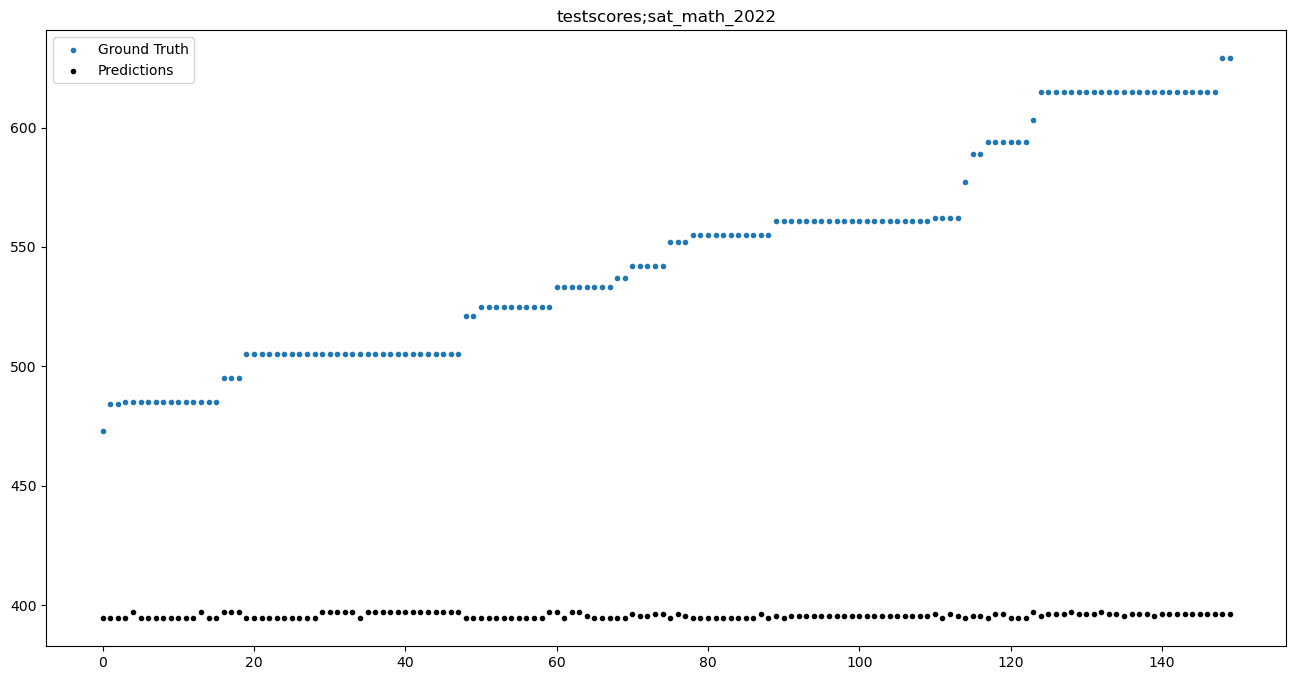

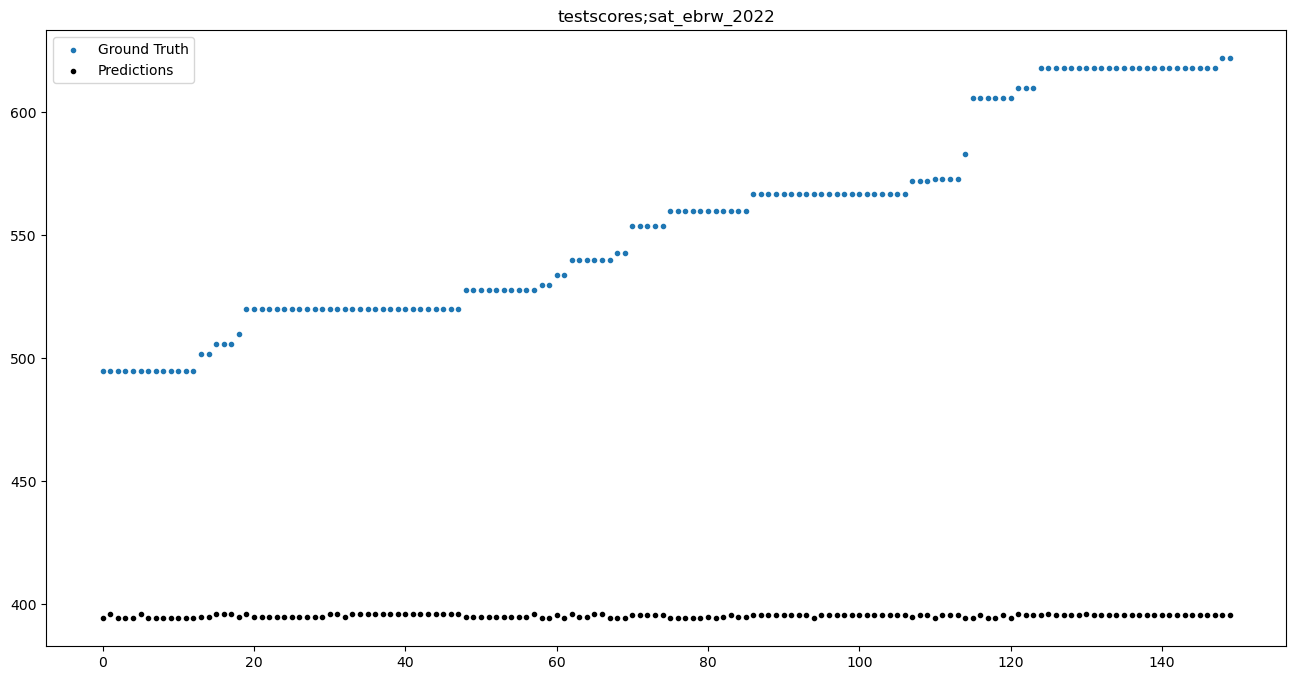

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_residuals(five_fold_results)

<a id='model1d_model'></a>

## Model 1d: Predict SAT Score Change from All Data

[(Back to top)](#models)

In [24]:
FEATURES = ['engagement;pct_access',
            'engagement;engagement_index',
            'districts;locale_city', 
            'districts;locale_suburb', 
            'districts;locale_town',
            'districts;locale_rural',
            'broadband;wired_over_25',
            'broadband;avg_mbps', 
            'broadband;frac_access', 
            'broadband;lowest_price']

TARGETS = ['testscores;sat_math_delta', 
           'testscores;sat_ebrw_delta']

model_type = NeuralNetRegressor(
                                RNNRegressor,
                                max_epochs=100,
                                criterion=torch.nn.MSELoss(),
                                lr=0.01,
                                # Shuffle training data on each epoch
                                iterator_train__shuffle=True,
                                # Network parameters
                                module__in_dim=len(FEATURES),
                                module__hidden_dim=64,
                                module__num_layers=3,
                                callbacks=[
                                    ('gradient_clipping',
                                     GradientNormClipping(gradient_clip_value=50.0)),
                                    ('early_stopping',
                                     EarlyStopping(patience=3)),
                                ],
)

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   TARGETS,
                                   model_type, 
                                   n_splits=5,
                                   scoring_metrics_list=['neg_root_mean_squared_error'],
                                   temporal=True)


Dataset for testscores;sat_math_delta has 150 samples after filtering
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      171.1730      217.0538  0.6763
      2      167.0404      215.0140  0.6563
      3      160.8364      213.6700  0.5924
      4      145.6036      224.9307  0.6274
      5      125.9895      222.5408  0.5664
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      212.0619      216.7376  0.6673
      2      202.3473      212.1786  0.6074
      3      188.3713      214.1242  0.6473
      4      155.4751      240.9403  0.5474
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      196.4416      190.4127  0.6953
      2      184.3856      181.9256  0.6883
      3      160.0342      196.9161  0.6753
      4 

<a id='model1d_results'></a>

### Model 1d Testing Results

[(Back to top)](#models)

In [25]:
print_results(five_fold_results, scoring_metrics_list=['neg_root_mean_squared_error'], splits=['test'])

,testscores;sat_math_delta
test_root_mean_squared_error,12.8454


testscores;sat_math_delta: 12.8454


,testscores;sat_ebrw_delta
test_root_mean_squared_error,13.8249


testscores;sat_ebrw_delta: 13.8249


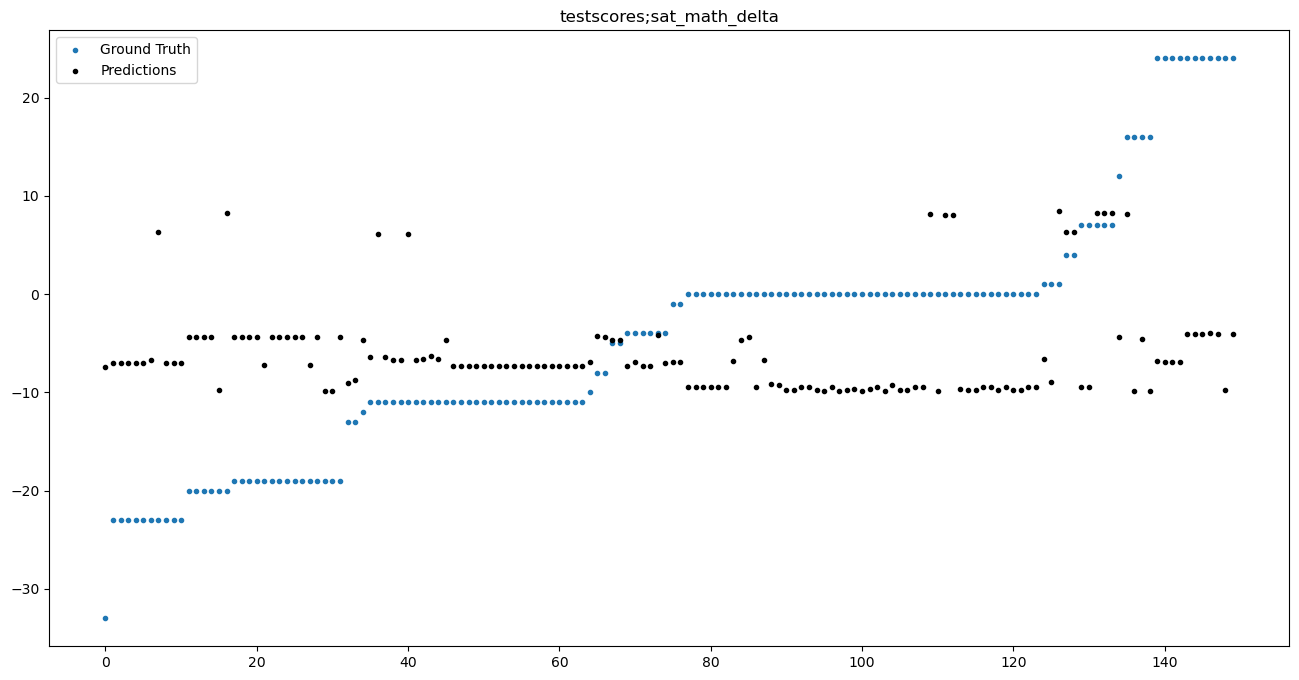

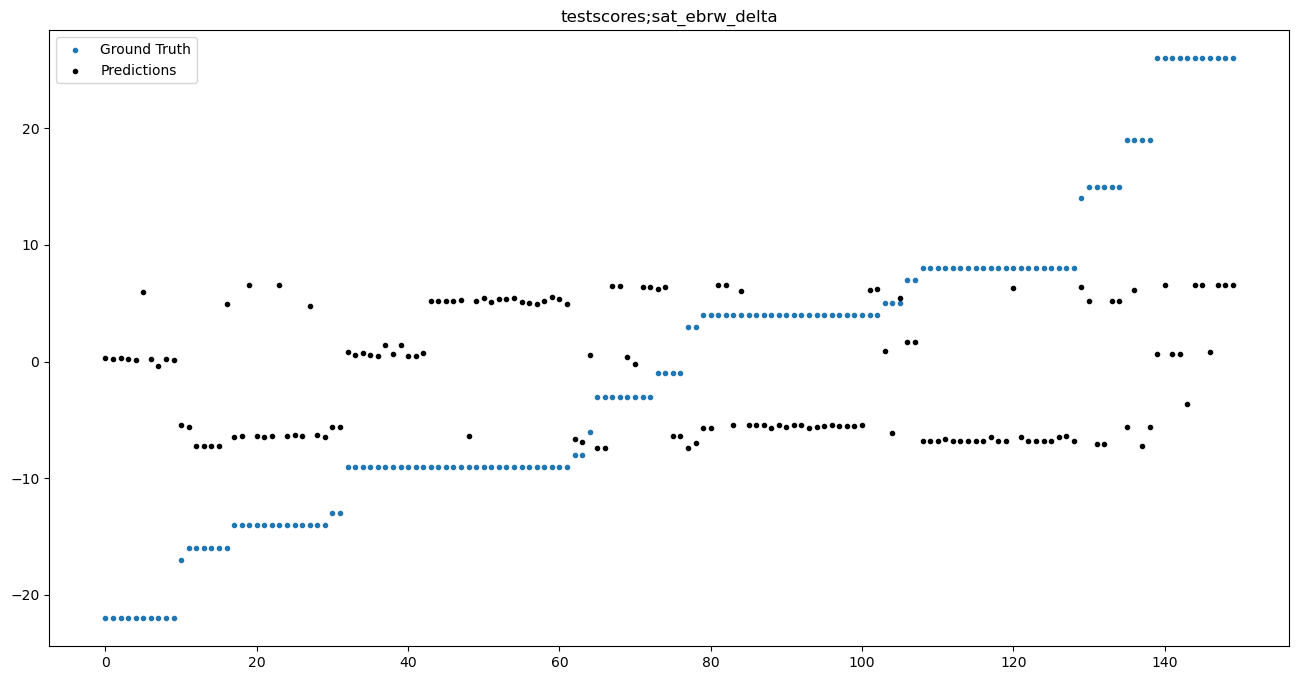

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_residuals(five_fold_results)

<a id='model2b_model'></a>

## Model 2b: Predict Change In 8th and 4th Grade Test Scores from Engagement and Locale (Best Baseline) Data

[(Back to top)](#models)

In [30]:
FEATURES = ['engagement;pct_access',
            'engagement;engagement_index',
            'districts;locale_city', 
            'districts;locale_suburb', 
            'districts;locale_town',
            'districts;locale_rural']

TARGETS = ['testscores;math_4_delta', 
           'testscores;math_8_delta', 
           'testscores;reading_4_delta', 
           'testscores;reading_8_delta']

model_type = NeuralNetRegressor(
                                RNNRegressor,
                                max_epochs=100,
                                criterion=torch.nn.MSELoss(),
                                lr=0.01,
                                # Shuffle training data on each epoch
                                iterator_train__shuffle=True,
                                # Network parameters
                                module__in_dim=len(FEATURES),
                                module__hidden_dim=64,
                                module__num_layers=3,
                                callbacks=[
                                    ('gradient_clipping',
                                     GradientNormClipping(gradient_clip_value=50.0)),
                                    ('early_stopping',
                                     EarlyStopping(patience=3)),
                                ],
)

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   TARGETS,
                                   model_type, 
                                   n_splits=5,
                                   scoring_metrics_list=['neg_root_mean_squared_error'],
                                   temporal=True)


Dataset for testscores;math_4_delta has 149 samples after filtering
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       28.2634       27.1314  0.6094
      2       22.7879       20.4012  0.6263
      3       16.4812       15.5320  0.6373
      4       12.1702       14.3772  0.6344
      5       11.3153       14.1676  0.6433
      6       11.1872       14.0379  0.5504
      7       11.0733       13.8803  0.5824
      8       10.9088       13.6574  0.6563
      9       10.6429       13.3426  0.5914
     10       10.1661       13.2115  0.6334
     11        9.5032       13.0626  0.6094
     12        9.0553       14.4555  0.6064
     13        9.9985       14.7186  0.5914
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       24.4497       31.5280  0.6184
      2       19.4454       24.5878  0.7003
      3       13.7983       18.

      5       13.6683       14.7040  0.5544
      6       13.6340       14.6951  0.5614
      7       13.6064       14.6898  0.5624
      8       13.5749       14.6879  0.5335
      9       13.5381       14.6915  0.5444
     10       13.4939       14.7050  0.5504
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       65.0825       58.8615  0.6863
      2       52.7158       39.7887  0.6923
      3       34.2728       18.2673  0.5784
      4       14.1696       13.4425  0.5474
      5       10.1607       13.1768  0.5784
      6       10.0446       13.1603  0.5924
      7       10.0412       13.1561  0.5764
      8       10.0385       13.1525  0.5584
      9       10.0358       13.1490  0.5844
     10       10.0330       13.1455  0.5864
     11       10.0303       13.1419  0.5545
     12       10.0275       13.1382  0.6004
     13       10.0246       13.1345  0.5734
     14    

      9       13.0917       12.2007  0.5215
     10       12.8565       11.8011  0.5105
     11       12.6689       12.1388  0.5455
     12       12.5547       12.9060  0.5255
Stopping since valid_loss has not improved in the last 3 epochs.
Dataset for testscores;reading_4_delta has 149 samples after filtering
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       14.8205       27.0688  0.6823
      2       12.7114       24.7036  0.6493
      3       11.0289       22.2465  0.6533
      4        9.3781       19.7822  0.6463
      5        7.8657       17.7476  0.6863
      6        6.7997       16.4750  0.6264
      7        6.2924       15.8449  0.6693
      8        6.1267       15.5686  0.6963
      9        6.0813       15.4522  0.6603
     10        6.0657       15.4030  0.6184
     11        6.0563       15.3814  0.6653
     12        6.0483       15.3708  0.6843
     13        6.0408       15.3646  0.7043
     14        6.0336       

     90        8.4643       14.3542  0.5884
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       17.1675       32.1611  0.6843
      2       15.0631       28.8009  0.6524
      3       13.0198       25.1238  0.6323
      4       11.0009       21.9529  0.6713
      5        9.5810       20.0943  0.6543
      6        9.0202       19.3033  0.6623
      7        8.8955       19.0131  0.6683
      8        8.8751       18.9081  0.6074
      9        8.8705       18.8664  0.6314
     10        8.8679       18.8455  0.6673
     11        8.8656       18.8314  0.6463
     12        8.8633       18.8196  0.6413
     13        8.8611       18.8084  0.6633
     14        8.8590       18.7973  0.5994
     15        8.8569       18.7862  0.6533
     16        8.8549       18.7751  0.6953
     17        8.8529       18.7639  0.6613
     18        8.8510       18.7527  0.6403
     19    

     10        8.0422       15.3060  0.6084
Stopping since valid_loss has not improved in the last 3 epochs.
Dataset for testscores;reading_8_delta has 147 samples after filtering
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       23.1611       23.8075  0.7662
      2       20.9389       21.4249  0.7982
      3       18.8086       18.7782  0.7342
      4       16.4862       16.1969  0.7333
      5       14.3344       14.4102  0.8471
      6       12.9965       13.5813  0.7912
      7       12.4807       13.2927  0.6543
      8       12.3281       13.2149  0.6673
      9       12.2647       13.2178  0.7013
     10       12.2182       13.2537  0.6653
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       21.8818       22.4382  0.6773
      2       19.7207       20.1831  0.6893
      3       17.7485       17.6891  0.7822
      4

     52        7.6227        5.8663  0.6234
     53        7.6179        5.8577  0.6703
     54        7.6129        5.8487  0.6164
     55        7.6078        5.8393  0.6114
     56        7.6026        5.8296  0.5964
     57        7.5973        5.8193  0.6203
     58        7.5918        5.8086  0.6633
     59        7.5862        5.7973  0.6214
     60        7.5804        5.7854  0.6164
     61        7.5745        5.7728  0.6633
     62        7.5685        5.7594  0.6324
     63        7.5623        5.7452  0.6483
     64        7.5560        5.7301  0.6503
     65        7.5495        5.7140  0.6324
     66        7.5429        5.6969  0.6673
     67        7.5361        5.6786  0.6553
     68        7.5292        5.6591  0.6463
     69        7.5222        5.6381  0.6663
     70        7.5150        5.6166  0.6743
     71        7.5078        5.5916  0.6863
     72        7.5007        5.5727  0.7053
     73        7.4954        5.5458  0.6593
     74        7.5058        5.6

<a id='model2b_results'></a>

### Model 2b Testing Results

[(Back to top)](#models)

In [31]:
print_results(five_fold_results, scoring_metrics_list=['neg_root_mean_squared_error'], splits=['test'])

,testscores;math_4_delta
test_root_mean_squared_error,3.4167


testscores;math_4_delta: 3.4167


,testscores;math_8_delta
test_root_mean_squared_error,3.9557


testscores;math_8_delta: 3.9557


,testscores;reading_4_delta
test_root_mean_squared_error,3.1949


testscores;reading_4_delta: 3.1949


,testscores;reading_8_delta
test_root_mean_squared_error,3.8177


testscores;reading_8_delta: 3.8177


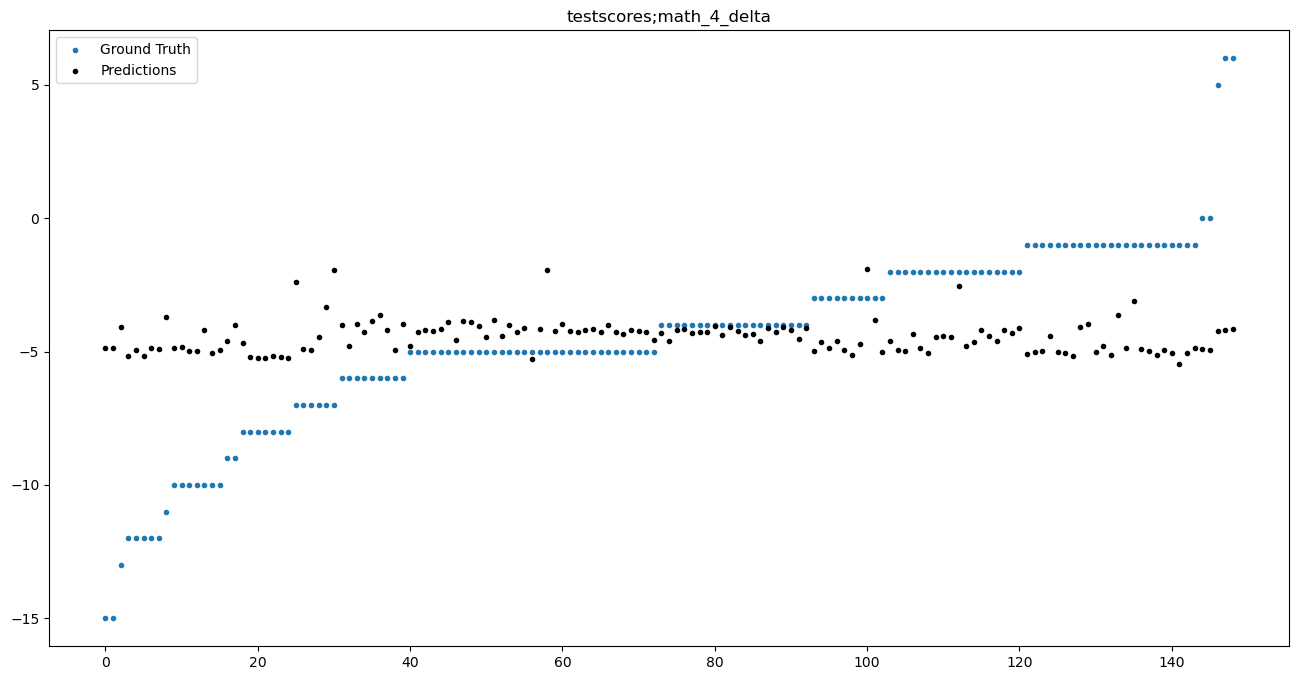

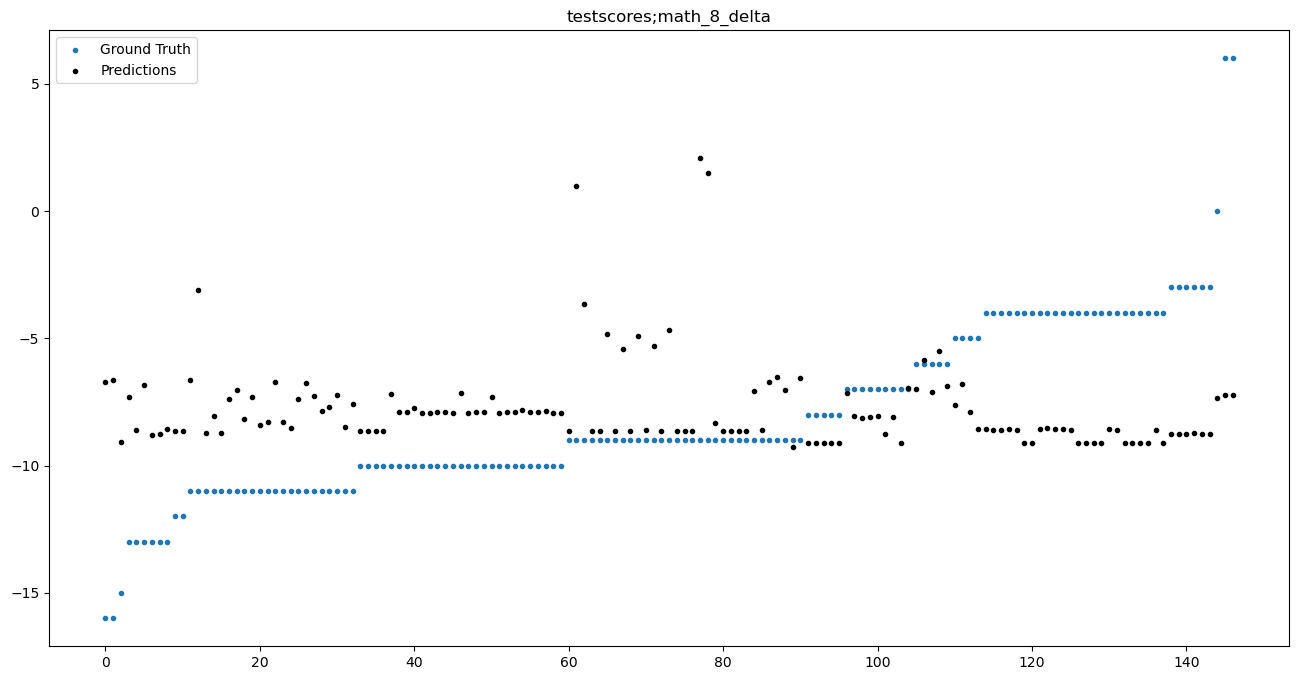

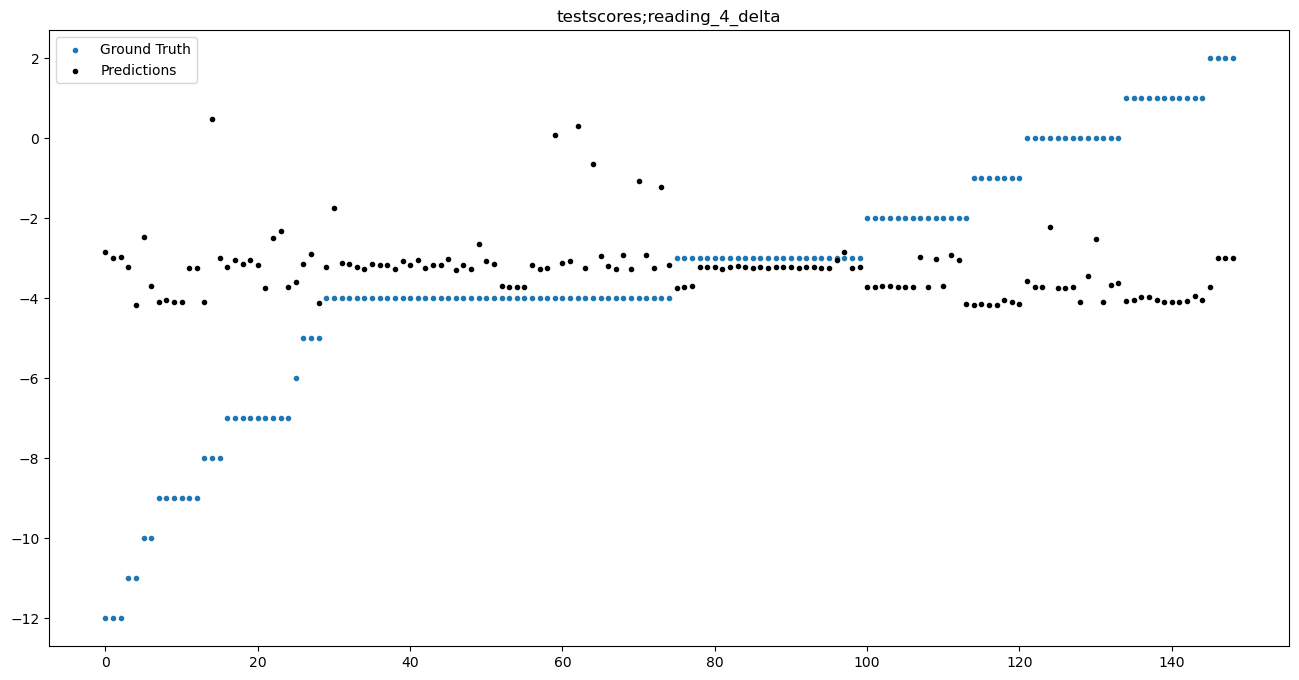

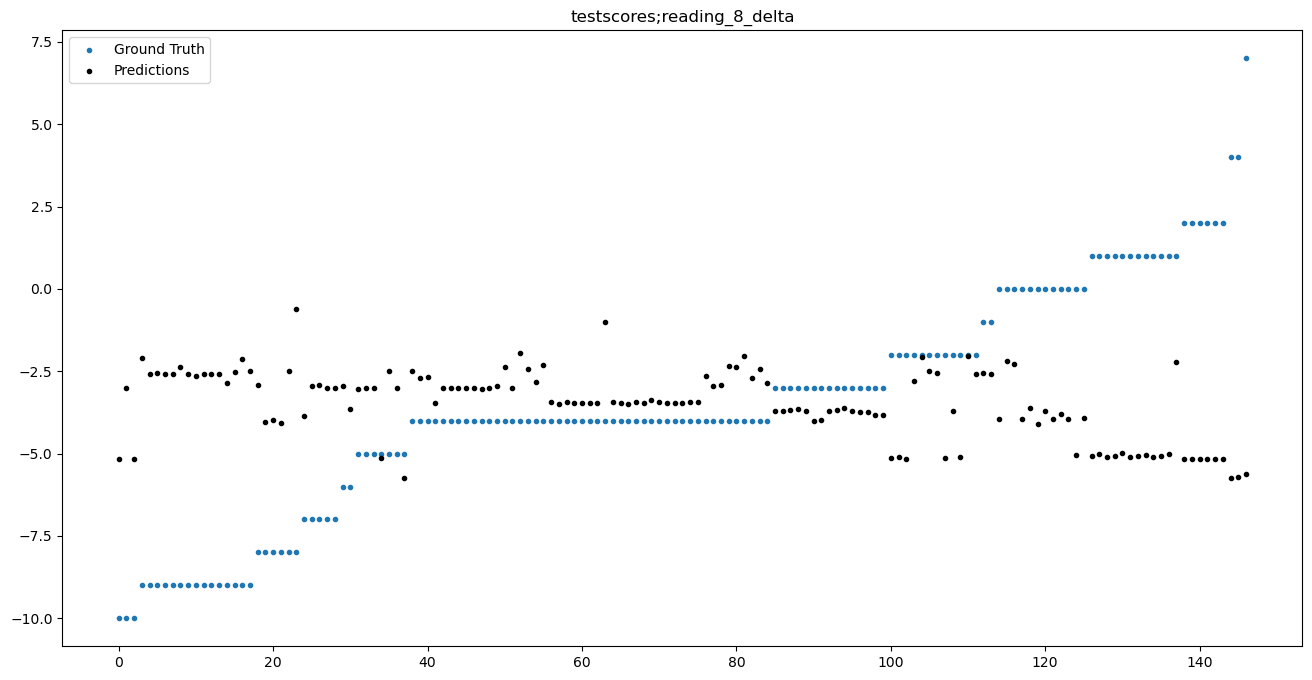

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_residuals(five_fold_results)

<a id='model2c_model'></a>

## Model 2c: Predict SAT Scores from Engagement (Best Baseline) Data

[(Back to top)](#models)

In [33]:
FEATURES = ['engagement;pct_access',
            'engagement;engagement_index']

TARGETS = ['testscores;sat_math_2022', 
           'testscores;sat_ebrw_2022']

model_type = NeuralNetRegressor(
                                RNNRegressor,
                                max_epochs=100,
                                criterion=torch.nn.MSELoss(),
                                lr=0.01,
                                # Shuffle training data on each epoch
                                iterator_train__shuffle=True,
                                # Network parameters
                                module__in_dim=len(FEATURES),
                                module__hidden_dim=64,
                                module__num_layers=3,
                                callbacks=[
                                    ('gradient_clipping',
                                     GradientNormClipping(gradient_clip_value=50.0)),
                                    ('early_stopping',
                                     EarlyStopping(patience=3)),
                                ],
)

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   TARGETS,
                                   model_type, 
                                   n_splits=5,
                                   scoring_metrics_list=['neg_root_mean_squared_error'],
                                   temporal=True)


Dataset for testscores;sat_math_2022 has 150 samples after filtering
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   311133.0000   296761.5312  0.7023
      2   309965.2188   294555.0000  0.5674
      3   307689.7812   291344.3438  0.6134
      4   304406.2188   287689.2188  0.5474
      5   300677.5312   283816.4062  0.5364
      6   296726.8750   279825.4688  0.4865
      7   292653.9062   275762.1250  0.4645
      8   288505.0000   271661.9062  0.4685
      9   284317.0000   267552.5000  0.4705
     10   280118.3750   263452.0312  0.4456
     11   275927.7188   259369.1406  0.4396
     12   271753.9688   255307.0156  0.4475
     13   267600.4375   251269.1094  0.4585
     14   263470.5938   247259.3594  0.4735
     15   259368.6719   243280.1875  0.4645
     16   255297.1406   239332.5469  0.4485
     17   251257.0000   235416.8750  0.5115
     18   247248.7656   231533.4219  0.4276
     19   243272.6406   227682.2656  0.4216
     20

     30   189172.7969   180640.4375  0.4575
     31   185704.1719   177243.3906  0.4415
     32   182268.0469   173878.8750  0.4845
     33   178864.3906   170546.8594  0.4545
     34   175493.2031   167247.2969  0.4675
     35   172154.5312   163980.2344  0.4645
     36   168848.3281   160745.6562  0.4336
     37   165574.6094   157543.5781  0.4885
     38   162333.3750   154374.0000  0.4515
     39   159124.6406   151236.9219  0.4795
     40   155948.3906   148132.3281  0.4535
     41   152804.6562   145060.2031  0.4116
     42   149693.3594   142020.6250  0.4685
     43   146614.5938   139013.5156  0.4575
     44   143568.3125   136038.8906  0.4565
     45   140554.5469   133096.7969  0.4396
     46   137573.2344   130187.1875  0.4296
     47   134624.4531   127310.0859  0.4515
     48   131708.1562   124465.4609  0.4026
     49   128824.3516   121653.3672  0.4216
     50   125973.0625   118873.7188  0.4296
     51   123154.2500   116126.6172  0.4605
     52   120367.9453   113411.9

     61    90459.1484    90148.0391  0.4515
     62    88067.8203    87759.6250  0.4575
     63    85708.9766    85403.6953  0.4535
     64    83382.6328    83080.2734  0.4376
     65    81088.8047    80789.3516  0.4046
     66    78827.4453    78530.9375  0.4136
     67    76598.6172    76305.0078  0.4625
     68    74402.2734    74111.5938  0.4156
     69    72238.4297    71950.6797  0.4196
     70    70107.0859    69822.2734  0.4235
     71    68008.2578    67726.3516  0.4166
     72    65941.9141    65662.9141  0.4096
     73    63908.0664    63632.0039  0.3976
     74    61906.7305    61633.5820  0.4525
     75    59937.8867    59667.6719  0.4346
     76    58001.5469    57734.2539  0.4595
     77    56097.7070    55833.3320  0.4146
     78    54226.3555    53964.9102  0.4445
     79    52387.5156    52129.0039  0.4076
     80    50581.1758    50325.5977  0.4525
     81    48807.3398    48554.6836  0.4675
     82    47065.9961    46816.2617  0.4396
     83    45357.1562    45110.3

     92    38617.1562    33476.5625  0.4415
     93    37091.7109    32043.4922  0.3986
     94    35598.7695    30642.9121  0.3906
     95    34138.3164    29274.8379  0.4276
     96    32710.3750    27939.2715  0.3976
     97    31314.9316    26636.2031  0.4445
     98    29951.9863    25365.6328  0.4236
     99    28621.5488    24127.5527  0.4375
    100    27323.5938    22921.9824  0.4336
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   310984.5938   295241.0000  0.5904
      2   309461.7188   292598.9375  0.6543
      3   306756.5938   289261.0000  0.6493
      4   303338.6875   285576.0625  0.5325
      5   299568.0312   281707.1250  0.5744
      6   295608.0000   277740.9062  0.5345
      7   291547.7188   273709.3438  0.5544
      8   287419.8125   269643.9688  0.4945
      9   283256.5000   265575.8438  0.4795
     10   279089.5625   261521.5156  0.5095
     11   274936.0000   257486.1406  0.5424
     12   270800.9375   253467.5

     21   242299.7344   228957.8594  0.5085
     22   238361.5625   225127.0000  0.4815
     23   234455.7969   221328.6094  0.5325
     24   230582.4375   217562.6875  0.4565
     25   226741.4531   213829.2344  0.4405
     26   222932.9844   210128.3125  0.4525
     27   219156.9219   206459.7969  0.4505
     28   215413.3125   202823.8281  0.4805
     29   211702.1875   199220.3281  0.4555
     30   208023.5000   195649.3594  0.4575
     31   204377.3125   192110.8594  0.4355
     32   200763.5781   188604.8594  0.4775
     33   197182.3750   185131.3594  0.4735
     34   193633.6250   181690.3281  0.4685
     35   190117.3594   178281.8281  0.4346
     36   186633.5625   174905.8281  0.4056
     37   183182.2656   171562.3281  0.4196
     38   179763.4531   168251.3281  0.4595
     39   176377.1719   164972.8281  0.4166
     40   173023.3281   161726.8281  0.4286
     41   169702.0156   158513.3281  0.4585
     42   166413.1719   155332.3438  0.4316
     43   163156.8281   152183.8

     52   126400.5000   120843.5859  0.4625
     53   123572.7578   118071.8359  0.4545
     54   120777.5000   115332.5859  0.4635
     55   118014.7422   112625.8359  0.5055
     56   115284.4922   109951.5859  0.5085
     57   112586.7266   107309.8359  0.4885
     58   109921.4766   104700.5859  0.4645
     59   107288.7266   102123.8203  0.4465
     60   104688.4688    99579.5703  0.4645
     61   102120.7188    97067.8203  0.5055
     62    99585.4609    94588.5625  0.4765
     63    97082.6953    92141.8203  0.4675
     64    94612.4375    89727.5703  0.4526
     65    92174.6875    87345.8125  0.4915
     66    89769.4297    84996.5625  0.4825
     67    87396.6641    82679.8125  0.4675
     68    85056.4141    80395.5703  0.5015
     69    82748.6641    78143.8125  0.4565
     70    80473.3984    75924.5625  0.4435
     71    78230.6484    73737.8203  0.4425
     72    76020.3828    71583.5703  0.4535
     73    73842.6484    69461.8281  0.5045
     74    71697.3906    67372.5

     83    48896.8438    48949.7070  0.4006
     84    47151.0312    47201.7695  0.4206
     85    45437.7227    45486.3125  0.4296
     86    43756.8945    43803.3750  0.4076
     87    42108.5820    42152.9414  0.4246
     88    40492.7773    40535.0039  0.4296
     89    38909.4648    38949.5625  0.4086
     90    37358.6484    37396.6094  0.4286
     91    35840.3281    35876.1758  0.4026
     92    34354.5195    34388.2383  0.4236
     93    32901.2031    32932.8008  0.4116
     94    31480.3887    31509.8672  0.4036
     95    30092.0781    30119.4297  0.4316
     96    28736.2637    28761.4844  0.4096
     97    27412.9434    27436.0527  0.4276
     98    26122.1328    26143.1191  0.4256
     99    24863.8184    24882.6855  0.4016
    100    23638.0059    23654.7500  0.4705
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   315696.0625   306908.5938  0.7213
      2   314651.0938   304869.7188  0.6344
      3   312545.1562   301735.0

     13   273735.5625   257998.4531  0.4515
     14   269550.5312   253932.8281  0.4405
     15   265397.1562   249899.2969  0.4875
     16   261275.7500   245897.9375  0.4645
     17   257186.4531   241928.8281  0.4385
     18   253129.3594   237992.1250  0.4575
     19   249104.5625   234087.7656  0.4415
     20   245112.0781   230215.8281  0.4465
     21   241151.9844   226376.3281  0.4216
     22   237224.3125   222569.2969  0.4595
     23   233329.0156   218794.6875  0.4515
     24   229466.1719   215052.5625  0.4226
     25   225635.8281   211342.8906  0.4715
     26   221837.8750   207665.7031  0.4315
     27   218072.4375   204021.0156  0.4585
     28   214339.4219   200408.8281  0.4525
     29   210638.9219   196829.1094  0.4425
     30   206970.9219   193281.8906  0.4615
     31   203335.3281   189767.1719  0.4495
     32   199732.2656   186284.9375  0.4306
     33   196161.6719   182835.1875  0.4605
     34   192623.5781   179417.9375  0.4266
     35   189118.0000   176033.1

<a id='model2c_results'></a>

### Model 2c Testing Results

[(Back to top)](#models)

In [34]:
print_results(five_fold_results, scoring_metrics_list=['neg_root_mean_squared_error'], splits=['test'])

,testscores;sat_math_2022
test_root_mean_squared_error,153.4811


testscores;sat_math_2022: 153.4811


,testscores;sat_ebrw_2022
test_root_mean_squared_error,161.6595


testscores;sat_ebrw_2022: 161.6595


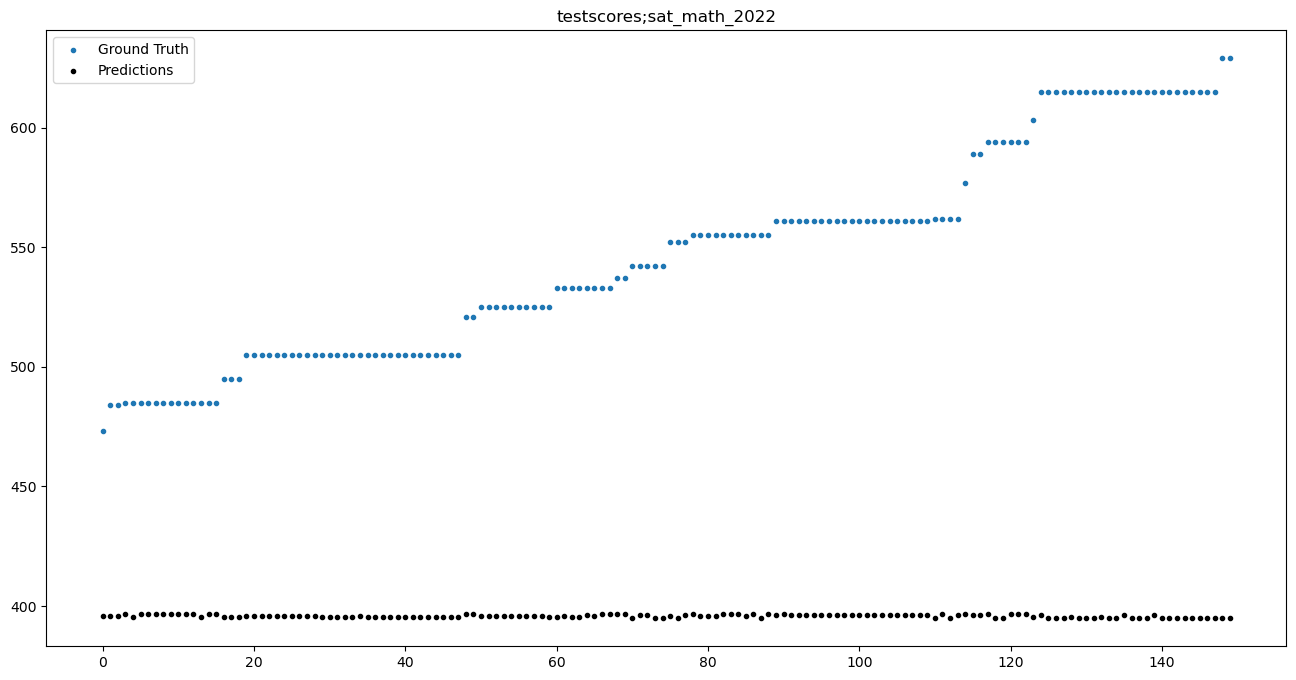

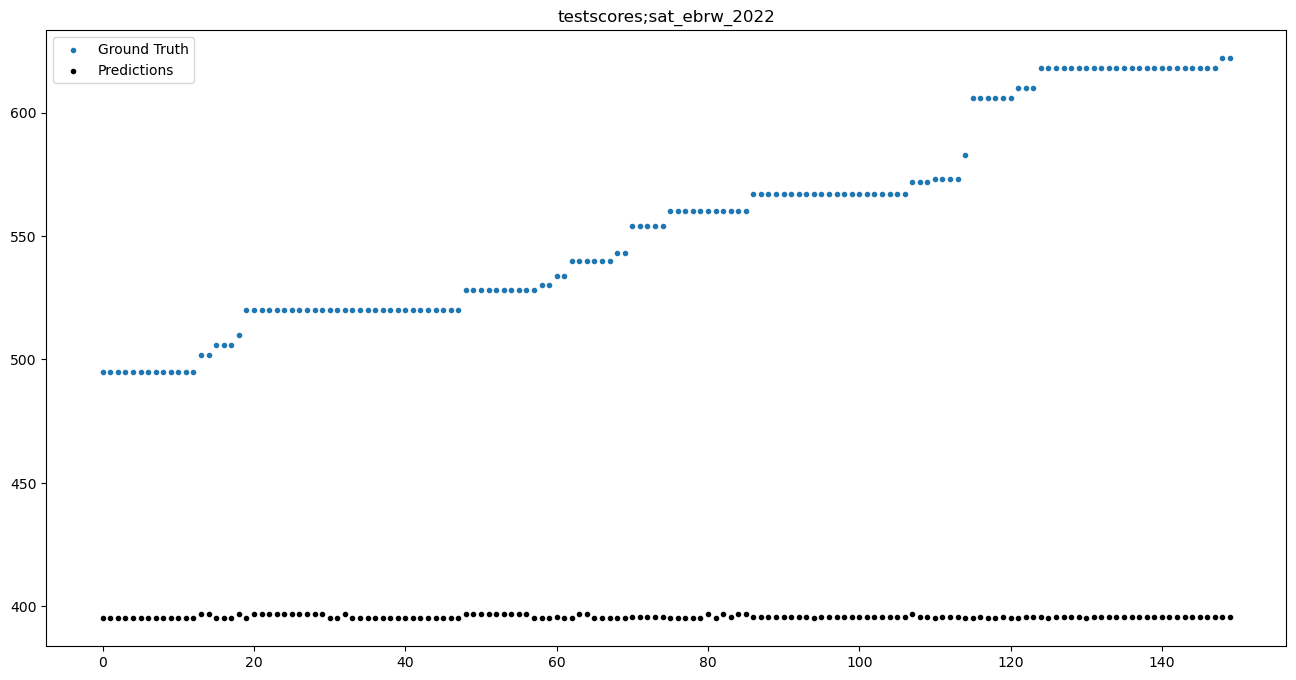

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_residuals(five_fold_results)

-------------